In [1]:
# # load dataset

# from datasets import load_dataset
# from tokenizers import ByteLevelBPETokenizer

# tokenizer = ByteLevelBPETokenizer()
# dataset = load_dataset("roneneldan/TinyStories")

# # Specify the split you want to save (e.g., "train", "validation", "test")
# split = "train"

# # Get the desired split from the dataset
# subset = dataset[split]

# # Save the subset to a text file
# subset.to_csv("tinystories-train.txt", sep="\t", index=False)


In [2]:
#----- imports --------

from tqdm import tqdm
import torch
from torch import nn
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json
from sae import TopKSparseAutoencoder


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"
torch.backends.cuda.matmul.allow_tf32 = True # for h100 gpu

config = {
    "learning_rate": 1e-3,
    "sae_learning_rate": 5e-5,
    "sae_size": 2**14,
    "sae_topk": 20,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 256,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v

model_name = "tiny-stories-model-normal-0.44-loss.pt"
# model_name = "tiny-stories-model-kurtosis-regularize-0.44-loss.pt"
sae_path = f"sae_models/sae-{model_name}"
model_path = f"models/{model_name}"


#wandb.init(
#    project = "tinystories",
#    config = config,
#)

torch.Size([128, 1024])


In [3]:

with open('tinystories-train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1922767089


In [5]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)


In [6]:

def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

from tqdm import tqdm

# def batch_encode(text, batch_size):
#     tokens = []
#     for i in tqdm(range(0, len(text), batch_size)):
#         tokens.extend(encode(text[i:i+batch_size]))
#     return tokens


hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)

[6099]
hello
vocab size:  8192


In [7]:
print("length of dataset in characters: ", len(text[:10000]))
print("length of dataset in tokens: ", len(encode(text[:10000])))
chars_per_token = len(text[:10000]) / len(encode(text[:10000]))
print("characters per token: ", chars_per_token)

length of dataset in characters:  10000
length of dataset in tokens:  2440
characters per token:  4.098360655737705


In [8]:
# load data from tiny-stories-train.pt
data = torch.load('tiny-stories-train.pt', map_location='cuda')#[:300000]

tensor_size_mb = data.element_size() * data.nelement() / (1024 ** 2)
print(f"Size of the tensor data: {tensor_size_mb:.2f} MB")


Size of the tensor data: 3571.81 MB


In [9]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [10]:
decode(data[:100].tolist())

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\nTogether'

In [11]:
# torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [12]:

import torch
import torch.nn as nn
from torch.nn import functional as F
# torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)


In [13]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return x

In [14]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([256, 256, 32])

In [15]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
        )

    def forward(self, x):
        return self.net(x)

In [16]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [17]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [18]:
class GPT(nn.Module):

    def __init__(self, n_layers):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
    
    def forward(self, idx, targets=None, return_residuals=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        if return_residuals == "first_embedding":
            return x

        def excess_kurtosis(emb):
            mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
            std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

            centralized = emb - mean #BxTxC
            fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
            kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
            # view as a 1d vector
            kurtosis = kurtosis.view(-1) - 3
            # make each one min 0
            kurtosis = torch.maximum(kurtosis, torch.tensor(0.0))
            # sum over the vector
            kurtosis = torch.sum(kurtosis)
            return kurtosis


        kurtosis_sum = torch.tensor(0.0)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            kurtosis_sum += excess_kurtosis(x)
            if return_residuals is not None and i == return_residuals:
                return x
        
        kurtosis_avg = kurtosis_sum / (len(self.layers) * T * B)

        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        if targets is None:
            return logits, None, kurtosis_avg
        else:
            # a list of all the predictions, reguardles of batch.
            # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
            # ydim: all predictions for all batches flattened (batch_dim*sequence_dim)
            logits_loss_view = logits.view(-1, vocab_size) 
            # targets loss view
            # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
            # so this would be like, [1,4,5,1,2,3, ...]
            # where each number is the correct next index of the one hot vector
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            return logits, loss, kurtosis_avg

    def generate(self, idx, max_new_tokens, temperature=0.5):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] # all batches, last token, all probabilities
            # apply temperature
            last_token_logits = last_token_logits / temperature
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    def prompt_model(self, prompt, max_new_tokens, temperature=0.5):
        autoregressive_seq = encode(prompt)
        for _ in range(max_new_tokens):
            prediction_index = len(autoregressive_seq)-1

            model_input = torch.tensor(autoregressive_seq)
            
            while model_input.shape[0] < T:
                pad_token = torch.tensor(encode("\n"))
                model_input = torch.cat((model_input, pad_token), dim=0)

            model_input
            model_input = model_input.unsqueeze(0)

            logits, loss, kurtosis_avg = model(model_input)
            prediction_token = logits[:, prediction_index, :] / temperature
            probabilities = F.softmax(prediction_token, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            autoregressive_seq.append(next_token)
        # get the autoregressive sequence
        return decode(autoregressive_seq)
    def get_embedding(self, prompt, override_model_embedding_layer=None):
        if override_model_embedding_layer is None:
            selected_model_embedding_layer = model_embedding_layer
        else:
            selected_model_embedding_layer = override_model_embedding_layer
        sequence = encode(prompt)
        model_input = torch.tensor(sequence)
        sequence_index = len(sequence) - 1
        while model_input.shape[0] < T:
            pad_token = torch.tensor(encode("\n"))
            model_input = torch.cat((model_input, pad_token), dim=0)
        model_input = model_input.unsqueeze(0)
        embedding = self.forward(model_input, return_residuals=selected_model_embedding_layer)
        # remove the batch dimension
        embedding = embedding.squeeze(0)[sequence_index]
        return embedding


    

model = GPT(n_layers)
logits, loss, kurtosis_avg = model(xb, yb)
print(logits.shape)
print(loss)
print(kurtosis_avg)




test_idx = torch.zeros(1, T).long()
model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

torch.Size([256, 256, 8192])
tensor(9.5217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0983, device='cuda:0', grad_fn=<DivBackward0>)


(tensor([[[ 2.6164, -0.6134, -0.7113,  ...,  0.8965, -1.7109,  1.5033],
          [ 2.0078, -1.3649, -0.8020,  ...,  0.1401, -0.2290,  2.1872],
          [ 2.0242, -2.1800, -0.0199,  ...,  1.1249, -0.1887,  1.4525],
          ...,
          [ 3.2808, -2.4087, -1.3399,  ...,  0.4888, -0.2276,  1.2932],
          [ 2.0272, -1.2375, -1.1003,  ...,  1.3614,  0.2643,  0.7792],
          [ 3.3301, -2.2375, -1.4751,  ...,  1.4019,  0.0290,  2.7653]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 None,
 tensor(0.1090, device='cuda:0', grad_fn=<DivBackward0>))

In [19]:
# load the model
model.load_state_dict(torch.load(model_path))
model.eval()
for param in model.parameters():
    param.requires_grad = False


Top 3 channels by magnitude:
1. Channel 125: -50.0975
2. Channel 192: 28.2912
3. Channel 162: -13.9752


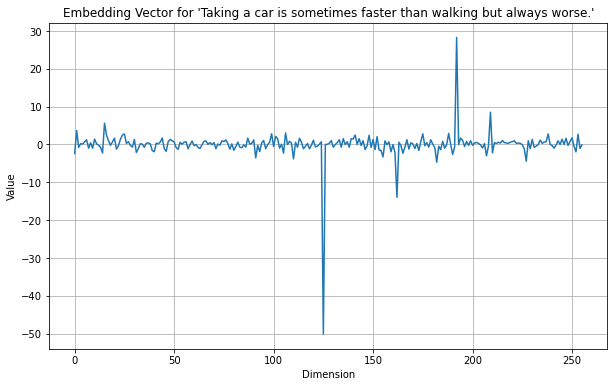

In [48]:
# emb = model.get_embedding("hello, world! I like pie", override_model_embedding_layer=6)
emb = model.get_embedding("Taking a car is sometimes faster than walking but always worse.", override_model_embedding_layer=6)
import matplotlib.pyplot as plt

# Assuming emb is a 1D tensor, convert it to a numpy array
emb_np = emb.cpu().detach().numpy()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(emb_np)), emb_np)
plt.title("Embedding Vector for 'Taking a car is sometimes faster than walking but always worse.'")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.grid(True)
# plt.Cars()

# Get the absolute values of the embedding
emb_abs = torch.abs(emb)

# Get the indices of the top 3 channels by magnitude
top_3_indices = torch.topk(emb_abs, k=3).indices

# Get the values of the top 3 channels
top_3_values = emb[top_3_indices]

# Print the results
print("Top 3 channels by magnitude:")
for i, (index, value) in enumerate(zip(top_3_indices.tolist(), top_3_values.tolist()), 1):
    print(f"{i}. Channel {index}: {value:.4f}")




In [20]:
print(model.prompt_model("<|endoftext|>\nOnce upon a time, there was a little boy named Tom", 200, 0.3))

<|endoftext|>
Once upon a time, there was a little boy named Tom. Tom loved to play with his toys and run around outside. One day, Tom saw a big, red ball. He wanted to play with it. So, Tom went to the ball and started to kick it. He kicked the ball with his nose and it went very fast.
Tom was very happy. He kicked the ball with his nose and it flew into the air. Tom was very happy. He played with the ball all day long. Tom was a happy boy.
<|endoftext|>
One day, a little boy named Tim went to the park with his mom. They saw a big tree with many leaves. Tim wanted to play with the leaves. He took one ball and threw it to the tree. The leaves went down the tree and made a loud noise.
Tim's mom said, "Tim, be careful not to fall. The leaves are too high and we can fall down." Tim nodded and said, "Okay, Mom. I will be careful."



# Sparse AutoEncoder

In [21]:
sae = TopKSparseAutoencoder(C, sae_size, sae_topk)

In [22]:
# load the model weights from the disk
sae.load_state_dict(torch.load(sae_path, map_location='cuda'))

# set the model to frozen weights
sae.eval()

for param in sae.parameters():
    param.requires_grad = False
    

for param in model.parameters():
    param.requires_grad = False

In [23]:

def get_context_window(split, ix):
    data = train_data if split == 'train' else val_data
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y


xb, yb = get_context_window("train", [1, 2, 3])

residuals = model(xb, return_residuals = model_embedding_layer)

sae_output = sae(residuals)
feature_activations = sae_output['feature_activations']


top_feature_indices = torch.argsort(feature_activations, dim=-1, descending=True)[:, :, :64]
top_feature_strengths = torch.gather(feature_activations, -1, top_feature_indices)



In [24]:

import torch
from typing import List, Dict, Tuple

class TokenFeatureStructure:
    def __init__(self, num_lists: int, tokens_per_list: int = 128, num_possible_features: int = 2**14, num_features_per_token: int = 64, top_k_features: int = 2**6):
        self.tokens_per_list = tokens_per_list
        self.num_possible_features = num_possible_features
        self.num_features_per_token = num_features_per_token
        self.top_k_features = top_k_features
        self.list_index = 0
        self.num_lists = num_lists
        
        # Store original lists of tokens
        self.token_lists = torch.zeros((num_lists, tokens_per_list), dtype=torch.long)
        
        # Store features and their strengths
        self.features = torch.zeros((num_lists, tokens_per_list, num_features_per_token), dtype=torch.long)
        self.strengths = torch.zeros((num_lists, tokens_per_list, num_features_per_token), dtype=torch.float32)

        # For each feature, store the top k locations (absolute index, flatten to recover the original)
        # we need 2 channels because we need the list index and the flattened lookup
        self.feature_locations_top_k = torch.zeros((num_possible_features, top_k_features, 2), dtype=torch.int64)
        self.feature_strengths_top_k = torch.full((num_possible_features, top_k_features), float('-inf'), dtype=torch.float32)
        # for each feature, store the lowest strength
        self.lowest_top_k_strengths = torch.zeros((num_possible_features), dtype=torch.float32) # index into via feature

        self.active_feature_counts = torch.zeros((num_possible_features), dtype=torch.int64)

        # itterate through the features, for each feature, set the top k 

    def add_featuretoken_list(self, tokens, features, strengths):
        list_index = self.list_index
        if list_index >= self.num_lists:
            raise ValueError(f"list_index {list_index} is greater than num_lists {self.num_lists}")
        # tokens: tokens_per_list ([a,b,c, ... n])
        # features: tokens_per_list x num_features ([[a,b,c, ... n], [a,b,c, ... n], ...]) 
        #            dim 0 is the token dimension, dim 1 is the feature dimension
        # strengths: tokens_per_list x num_features ([[a,b,c, ... n], [a,b,c, ... n], ...])
        #            dim 0 is the token dimension, dim 1 is the feature dimension
        # each feature, strength corresponds to a token of the same index

        # assert the features per token is num_features_per_token
        assert features.shape[-1] == self.num_features_per_token, f"Expected {self.num_features_per_token} features per token, but got {features.shape[1]}"
        assert strengths.shape[-1] == self.num_features_per_token, f"Expected {self.num_features_per_token} strengths per token, but got {strengths.shape[1]}"


        # sort the features by strength
        sorted_indices = torch.argsort(strengths, dim=-1)
        sorted_features = torch.gather(features, 1, sorted_indices)
        sorted_strengths = torch.gather(strengths, 1, sorted_indices)


        # Save to class
        self.token_lists[list_index] = tokens
        self.features[list_index] = sorted_features
        self.strengths[list_index] = sorted_strengths


        for i, feature in enumerate(sorted_features.view(-1)):
            feature_strength = sorted_strengths.view(-1)[i]
            if feature_strength == 0:
                continue
            self.active_feature_counts[feature] += 1
            # get the last if the top_k_strengths
            if feature_strength > self.feature_strengths_top_k[feature][0]: # our feature str > lowest top k of this feat.
                # find the maximum index less than feature_strength
                min_index = torch.searchsorted(self.feature_strengths_top_k[feature], feature_strength) - 1
                value = feature_strength
                temp = self.feature_strengths_top_k[feature].clone()
                self.feature_strengths_top_k[feature][0:min_index] = temp[1:min_index+1]
                self.feature_strengths_top_k[feature][min_index] = value

                temp = self.feature_locations_top_k[feature].clone()
                self.feature_locations_top_k[feature][0:min_index] = temp[1:min_index+1]
                self.feature_locations_top_k[feature][min_index] = torch.tensor([list_index, i])
        self.list_index += 1


    
    def get_top_k_for_feature(self, feature: int) -> Tuple[torch.Tensor, torch.Tensor]:
        locations = self.feature_locations_top_k[feature]
        strengths = self.feature_strengths_top_k[feature]
        return locations, strengths
    def print(self):
        print("token lists:")
        print(self.token_lists)
        print("features:")
        print(self.features)
        print("strengths:")
        print(self.strengths)
        print("feature locations top k:")
        print(self.feature_locations_top_k)
        print("feature strengths top k:")
        print(self.feature_strengths_top_k)
    

t = TokenFeatureStructure(
    4, # num lists
    3, # tokens per list
    3, # num possible features
    3, # num_features_per_token
    2 # top_k_features
)


# list 0, tokens [1,2,3], features [[0,1,2], [0,1,2], [0,1,2]], strengths [[1,2,3], [1,2,3], [1,2,3]]
t.add_featuretoken_list(
    torch.tensor([1,2,3]), # tokens
    torch.tensor([[0,1,2], [0,1,2], [0,1,2]]), # features per token
    torch.tensor([[1,2,3], [1,2,3], [3,2,1]], # strengths per feature
    dtype=torch.float32))
t.add_featuretoken_list(
    torch.tensor([3,4,5]), # tokens
    torch.tensor([[0,1,2], [0,1,2], [0,1,2]]), # features per token
    torch.tensor([[4,5,6], [1,2,3], [3,2,1]], # strengths per feature
    dtype=torch.float32))


t.print()

token lists:
tensor([[1, 2, 3],
        [3, 4, 5],
        [0, 0, 0],
        [0, 0, 0]], device='cuda:0')
features:
tensor([[[0, 1, 2],
         [0, 1, 2],
         [2, 1, 0]],

        [[0, 1, 2],
         [0, 1, 2],
         [2, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], device='cuda:0')
strengths:
tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[4., 5., 6.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0')
feature locations top k:
tensor([[[0, 8],
         [1, 0]],

        [[0, 1],
         [1, 1]],

        [[0, 2],
         [1, 2]]], device='cuda:0')
feature strengths top k:
tensor([[3., 4.],
        [2., 5.],
        [3., 6.]], device='cuda:0')


In [25]:
for batch in residuals:
    print(batch.shape)

torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


In [26]:
idx =  1
get_context_window('train', [idx*T])

(tensor([[ 262,  684,  264, 1117,  262, 1510, 1546,  345,  440,   13,  314,  866,
           264, 7995,  353, 2843,   13,  198, 7610,  776,  342,  262, 4164, 1510,
           489,  357,   13,  961,  303,  281,  404,  265,  442,  592,   11, 2630,
           596,  708,  278, 1417,  688, 4815,   13,  314,  475,  265,  262, 4815,
          1152,  264,  621,  688, 2187, 4815,   13, 1485,   11, 2630,  596,  281,
          1278,  265,  442,  852,  264,  360,  590,  262, 1011,  357,   13,  845,
          2630,  596,  918, 1389, 1073, 1057,   13,  198,  379,  382,  380,  198,
           427,  357,   11,  258,  405, 1090,  507, 3544,  281, 2115, 1082,  262,
          2613,   13,  314,  419,  258,  413, 2459,  264,  450,  265,  332,  486,
            13,  328, 1777,   11,  335, 1156, 3544,   13, 1250,  346,  386,  265,
           360,  484,  515,  262,  405, 1090,   13,  298, 2459,  521,  456, 3544,
           264,  326,   11,  328,  940,   11,  335,  827,  430,  386,  265,  360,
            13, 

In [27]:
num_features_per_token = sae_topk
num_context_windows = 128
tokenfeatures = TokenFeatureStructure(
    num_lists=num_context_windows,
    tokens_per_list=T,
    num_features_per_token=num_features_per_token,
    num_possible_features=2**14,
    top_k_features=32)



num_saves = 0
with torch.no_grad():
    data = train_data
    for i in tqdm(range(0, T*num_context_windows, T)): 
        # B ixs, step is T, start at i
        xb, yb = get_context_window('train', [i])
        residuals = model(xb, return_residuals=model_embedding_layer) # B, T, C
        sae_output = sae(residuals)
        feature_activations = sae_output['feature_activations']
        top_feature_indices = torch.argsort(feature_activations, dim=-1, descending=True)[:, :, :num_features_per_token]
        top_feature_strengths = torch.gather(feature_activations, -1, top_feature_indices)[0]
        top_feature_indices = top_feature_indices[0]
        tokens = xb[0]
        tokenfeatures.add_featuretoken_list(tokens, top_feature_indices, top_feature_strengths)
        num_saves += 1
        if num_saves == num_context_windows:
            print("breaking")
            print(num_saves)
            break
    
    
    
    

 99%|█████████▉| 127/128 [01:55<00:00,  1.10it/s]

breaking
128


In [28]:
# active_feature_counts = tokenfeatures.active_feature_counts

# plt.figure(figsize=(10, 6))
# plt.hist(active_feature_counts.cpu().detach().numpy(), bins=64, edgecolor='black')
# plt.xlabel('Feature Count')
# plt.ylabel('Frequency')
# plt.title('Histogram of Active Feature Counts')
# plt.show()

# import numpy as np

# # Calculate quartiles
# active_feature_counts_np = active_feature_counts.cpu().detach().numpy()
# quartiles = np.percentile(active_feature_counts_np, [25, 50, 75])

# # Generate report
# print("Report of Quartiles of Active Feature Counts:")
# print(f"1st Quartile (25th percentile): {quartiles[0]}")
# print(f"2nd Quartile (Median, 50th percentile): {quartiles[1]}")
# print(f"3rd Quartile (75th percentile): {quartiles[2]}")

# # Get the greatest active feature count
# greatest_active_feature_count = torch.max(active_feature_counts).item()
# print(f"Greatest Active Feature Count: {greatest_active_feature_count}")



In [30]:
feature_strengths_topk = tokenfeatures.feature_strengths_top_k

active_features_mask = torch.where(feature_strengths_topk>0, torch.tensor(1), torch.tensor(0))

active_features_per_feature = active_features_mask.sum(dim=-1)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.hist(active_features_per_feature.cpu().detach().numpy(), bins=64, edgecolor='black')
# plt.xlabel('Total Number of Active Features')
# plt.ylabel('# of 16k features with this many appearances in top k toks over all tokens')
# plt.title('Histogram of Active Features per Feature')
# plt.show()


In [31]:
def analyze_feature_occurrences(n=20, occurrence_idx=0, tokens_around=5):
    # Get features which occur n times
    features_occurring_n_times = torch.where(active_features_per_feature == n)[0]
    # print(f"Features which occur {n} times: {features_occurring_n_times}")

    feature = features_occurring_n_times[occurrence_idx]
    print(f"Feature idx: {feature.item()}")

    locations, strengths = tokenfeatures.get_top_k_for_feature(feature)
    locations = torch.flip(locations, dims=[0])
    strengths = torch.flip(strengths, dims=[0])

    occurrence_strings = []

    for occurrence_idx in range(len(locations)):
        location = locations[occurrence_idx]
        list_idx = location[0]
        featuresequence_idx = location[1]

        # print(f"List Index: {list_idx}, featuresequence_idx: {featuresequence_idx}")

        # print("# lookup in all features")
        # print("- idx")
        # print(tokenfeatures.features[list_idx].view(-1)[featuresequence_idx])
        # print("- strength")
        # print(tokenfeatures.strengths[list_idx].view(-1)[featuresequence_idx])

        # get the token idx from the featuresequence idx:
        # print("# Location in tokens")
        token_idx = featuresequence_idx // num_features_per_token
        feature_idx = featuresequence_idx % num_features_per_token
        # print(f"Token Index: {token_idx}")
        # print(f"Feature Index: {feature_idx}")

        strength = tokenfeatures.strengths[list_idx][token_idx][feature_idx].item()
        feature_idx = tokenfeatures.features[list_idx][token_idx][feature_idx].item()

        token = tokenfeatures.token_lists[list_idx][token_idx]
        token_decoded = decode([token.item()])

        begin_idx = max(0, token_idx - tokens_around)
        end_idx = min(tokenfeatures.tokens_per_list, token_idx + tokens_around)

        sequence = tokenfeatures.token_lists[list_idx][begin_idx:end_idx]
        sequence_decoded = decode(sequence.tolist())

        occurrence_strings.append({
            "strength": strength,
            "feature_idx": feature_idx,
            "token_decoded": token_decoded,
            "sequence_decoded": sequence_decoded
        })

    return occurrence_strings

# Call the function
import json

# occurrence_strings = analyze_feature_occurrences(n=20, occurrence_idx=1, tokens_around=6) # fleeing
# occurrence_strings = analyze_feature_occurrences(n=20, occurrence_idx=5, tokens_around=6) # brothers = bears
occurrence_strings = analyze_feature_occurrences(n=10, occurrence_idx=1, tokens_around=10) # Fish/water/ocean
# occurrence_strings = analyze_feature_occurrences(n=30, occurrence_idx=2, tokens_around=6)
for occurrence_string in occurrence_strings:
    print(json.dumps(occurrence_string, indent=4))


Feature idx: 76
{
    "strength": 8.588500022888184,
    "feature_idx": 76,
    "token_decoded": "E",
    "sequence_decoded": " and all the animals felt cool and happy.\nElly learned that being different was not ugly."
}
{
    "strength": 6.995067119598389,
    "feature_idx": 76,
    "token_decoded": "ant",
    "sequence_decoded": " stove granted all of Ella's wishes in an instant. Ella was so happy. She thanked the"
}
{
    "strength": 4.524333953857422,
    "feature_idx": 76,
    "token_decoded": " sp",
    "sequence_decoded": " grass swayed in the breeze.\nSuddenly, Spot spied something shiny in the grass and scrambled to"
}
{
    "strength": 3.7588608264923096,
    "feature_idx": 76,
    "token_decoded": " sp",
    "sequence_decoded": " loved spicy food. He always used to pick the spiciest of all the food in the village"
}
{
    "strength": 2.961914539337158,
    "feature_idx": 76,
    "token_decoded": " rever",
    "sequence_decoded": " fun! You now know that you can explore by re

In [32]:
import re
import anthropic

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=open('.anthropic.key').read().strip(),
)

def analyze_common_feature(text1, text2, text3, text4, retires=1):

    # Parse the output
    try:
        message = client.messages.create(
            model="claude-3-5-sonnet-20240620",
            max_tokens=1000,
            temperature=0,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"You will be given four slices of text. Your task is to find the best rule that all of them follow. Do not detail what is present in each text.\nHere are the four pieces of text:\n\n<text1>\n{text1}\n</text1>\n\n<text2>\n{text2}\n</text2>\n\n<text3>\n{text3}\n</text3>\n\n<text4>\n{text4}\n</text4>\n\n\n\nProvide your response in the following format:\n\n<common_feature>\nThe identified common feature (or \"No common feature identified\")\n</common_feature>"
                        }
                    ]
                }
            ]
        )

        content = message.content[0].text
        common_feature = content.split('<common_feature>')[1].split('</common_feature>')[0].strip()
        if common_feature == "No common feature identified":
            return False
        return common_feature
    except Exception as e:
        print(f"Exception occurred: {e}")
        if retires == 0:
            print("Failed to analyze common feature too many times, skipping")
            return False
        return analyze_common_feature(text1, text2, text3, text4, retires-1)

def test_rule(rule, text1, text2, text3, text4, retires=1):

    # Parse the output
    try:
        message = client.messages.create(
            model="claude-3-5-sonnet-20240620",
            max_tokens=1000,
            temperature=0,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"You will be given four pieces of text, and a rule that one of the pieces of text follows. Your task is to find text that best follows the rule.\nHere the rule is: {rule}\nHere are the four pieces of text:\n\n<text1>\n{text1}\n</text1>\n\n<text2>\n{text2}\n</text2>\n\n<text3>\n{text3}\n</text3>\n\n<text4>\n{text4}\n</text4>\n\n\n\nProvide your response in the following format:\n\n<best_text>\nThe identified text best matching the rule (1,2,3,4)\n</best_text>"
                        }
                    ]
                }
            ]
        )

        content = message.content[0].text
        best_text = content.split('<best_text>')[1].split('</best_text>')[0].strip()
        # get the first numeric character
        best_text = int(re.search(r'\d', best_text).group())
        return best_text - 1
    except Exception as e:
        print(f"Exception occurred: {e}")
        if retires == 0:
            print("Failed to get best example many times, skipping")
            return False
        return test_rule(text1, text2, text3, text4, retires-1)

feature_description =  analyze_common_feature("Flowing through the channel, the water rushed", "Frigid water near the.", "The ocean was vast.", "The fish was swimming.")
print(feature_description)
test_rule(feature_description, "The whale was angry.", "the sky is red.", "cars are fun.", "I am diego.")




Each text contains a reference to water or a water-related environment.


0

In [34]:
import random
# construct automatic interpretability dataset
# each feature: 4x example, 2x label, 6x random other features


# ocurrences is how you spell it
      # ocurrences
feature_occurences = []
for i in range(6, 26):
    occurrences_details = analyze_feature_occurrences(n=i, occurrence_idx=0, tokens_around=9)
    feature_occurences.append(occurrences_details[:6])

def construct_dataset(idx):
    positive_examples = []
    for i in range(6):
        positive_examples.append(feature_occurences[idx][i]['sequence_decoded'])
    # get 6 random features from the saved ones
    idxs = [i for i in range(0, len(feature_occurences))]
    idxs.remove(idx)
    random.shuffle(idxs)
    wrong_feature_idxs = idxs[:6]
    negative_examples = []
    for feature_idx in wrong_feature_idxs:
        negative_examples.append(feature_occurences[feature_idx][random.randint(0,5)]['sequence_decoded']) # get a random example for each of the negative features
    random.shuffle(positive_examples)
    random.shuffle(negative_examples)

    feature_examples = positive_examples[0:4]
    
    test1 = []
    test1.extend(negative_examples[0:3])
    test1.append(positive_examples[4])

    test2 = []
    test2.extend(negative_examples[3:6])
    test2.append(positive_examples[5])

    random.shuffle(test1)
    random.shuffle(test2)

    # get the index of the positive example
    positive_index_test1 = test1.index(positive_examples[4])
    positive_index_test2 = test2.index(positive_examples[5])

    return {
        'examples': feature_examples,
        'test1': {
            'examples': test1,
            'positive_index': positive_index_test1
        },
        'test2': {
            'examples': test2,
            'positive_index': positive_index_test2
        }
    }
    




class LabeledFeature:
    def __init__(self):
        self.feature_idx = None
        self.examples = None
        self.description = None
        self.test1 = None
        self.test2 = None
        self.interpretability_score = None
        self.feature_details = None

    def __repr__(self):
        return f"Feature {self.feature_idx}: {self.description}"
    def initialize_from_data(self, feature_details, experiment_feature_idx):
        self.feature_details = feature_details
        self.experiment_feature_idx = experiment_feature_idx

        feature_idx = feature_details[0]['feature_idx']
        dataset = construct_dataset(experiment_feature_idx)
        examples = dataset['examples']
        test1 = dataset['test1']
        test2 = dataset['test2']

        self.feature_idx = feature_idx
        self.examples = examples
        self.description = None
        self.test1 = test1
        self.test2 = test2
    def do_tests(self):
        if self.description == None:
            raise ValueError("No description learned")
        elif self.description == False:
            return 0

        test1_answer = test_rule(self.description, *self.test1['examples'])
        test2_answer = test_rule(self.description, *self.test2['examples'])
        test1_score = 1 if test1_answer == self.test1['positive_index'] else 0
        test2_score = 1 if test2_answer == self.test2['positive_index'] else 0
        result_string = f"Test 1: {'Correct' if test1_score == 1 else 'Incorrect'}\nTest 2: {'Correct' if test2_score == 1 else 'Incorrect'}"
        self.interpretability_score = (test1_score + test2_score)/2
        return (test1_score + test2_score)/2, result_string
    def learn_description(self):
        description = analyze_common_feature(*self.examples)
        self.description = description
        return description

test1 = {
    'examples': ['the balcony overlooked the city', 'He stabbed the man in the back.', 'drywall was not suitable for the', 'happiness stems from a good heart'],
    'positive_index': 1
}

test2 = {
    'examples': ['The whale was grey.', 'the sky is red.', 'AI should be in jail.', 'I am diego.'],
    'positive_index': 2
}


lf = LabeledFeature()
lf.examples = ['I like stealing stuff.', 'arson is fun.', 'the man ran from the police', 'he robbed the bank']
lf.test1 = test1
lf.test2 = test2

lf.learn_description()
print(lf.description)
lf.do_tests()

Feature idx: 85
Feature idx: 14
Feature idx: 134
Feature idx: 87
Feature idx: 72
Feature idx: 78
Feature idx: 11
Feature idx: 30
Feature idx: 81
Feature idx: 60
Feature idx: 250
Feature idx: 644
Feature idx: 211
Feature idx: 142
Feature idx: 653
Feature idx: 18
Feature idx: 596
Feature idx: 516
Feature idx: 175
Feature idx: 183
Each text describes or implies criminal activity.


(1.0, 'Test 1: Correct\nTest 2: Correct')

In [35]:

labeled_features = []

for i, feature in enumerate(feature_occurences):
    lf = LabeledFeature()
    lf.initialize_from_data(feature, i)
    labeled_features.append(lf)

for feature in labeled_features:
    feature.learn_description()
    print(feature.description)
    print(feature.do_tests())

All four texts contain the word "Soon" followed by a comma, introducing a new action or development in the narrative.
Exception occurred: list index out of range
Exception occurred: 'NoneType' object has no attribute 'group'
(0.5, 'Test 1: Incorrect\nTest 2: Correct')
Each text snippet contains a reference to a person or people, either by name or by a descriptive term (e.g., "caretaker," "little girl," "Mummy").
(0.0, 'Test 1: Incorrect\nTest 2: Incorrect')
Each text snippet contains exactly 70 characters, including spaces and punctuation.
(0.5, 'Test 1: Correct\nTest 2: Incorrect')
All texts contain dialogue or quoted speech, followed by narration describing actions or reactions related to the dialogue.
(1.0, 'Test 1: Correct\nTest 2: Correct')
Each text snippet is an incomplete sentence or thought, ending abruptly without proper closure or punctuation.
(1.0, 'Test 1: Correct\nTest 2: Correct')
Each text snippet contains a form of movement or travel, typically involving a transition f

In [36]:
idx = 2
print(labeled_features[idx].interpretability_score)
print(labeled_features[idx].examples)
print(labeled_features[idx].description)
labeled_features[idx].feature_details

0.5
[', demonstrating his dependable strength. Inside, he found the lumber he', ' stopped to look at it and noticed that the base of the tree was empty. Anna decided', " its wings and dropped the toy in Molly's lap. \nMolly was amazed and asked", 'John quickly improved his toy boat, since his strength was now dependable']
Each text snippet contains exactly 70 characters, including spaces and punctuation.


[{'strength': 9.86795425415039,
  'feature_idx': 134,
  'token_decoded': ' body',
  'sequence_decoded': ' was good to slow down and listen to his body. And Max and his friends played happily'},
 {'strength': 5.710468769073486,
  'feature_idx': 134,
  'token_decoded': ' strength',
  'sequence_decoded': ', demonstrating his dependable strength. Inside, he found the lumber he'},
 {'strength': 5.438358783721924,
  'feature_idx': 134,
  'token_decoded': ' strength',
  'sequence_decoded': 'John quickly improved his toy boat, since his strength was now dependable'},
 {'strength': 5.231358528137207,
  'feature_idx': 134,
  'token_decoded': ' lap',
  'sequence_decoded': " its wings and dropped the toy in Molly's lap. \nMolly was amazed and asked"},
 {'strength': 4.664125442504883,
  'feature_idx': 134,
  'token_decoded': ' base',
  'sequence_decoded': ' stopped to look at it and noticed that the base of the tree was empty. Anna decided'},
 {'strength': 3.6341171264648438,
  'feature_idx': 134,


In [37]:
total_score = 0
for lf in labeled_features:
    if lf.interpretability_score is not None:
        total_score += lf.interpretability_score
mean_interpretability_score = total_score / len(labeled_features)
print(mean_interpretability_score)

0.575


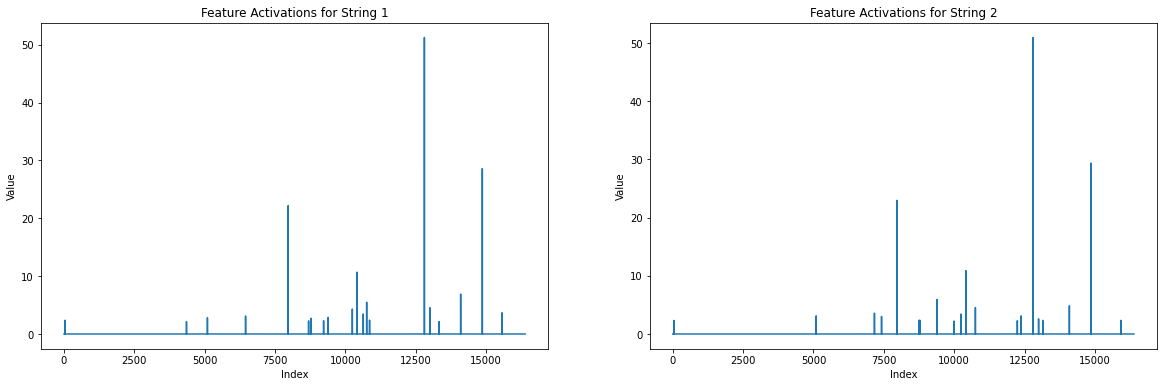

<Figure size 1440x432 with 0 Axes>

Number of overlapped top k features: 12
Number of active features for String 1: 20
Number of active features for String 2: 20


In [86]:


def process_input_string(input_string):
    embedding = model.get_embedding(input_string)


    sae_output = sae(embedding)
    encoded = sae_output['encoded']
    decoded = sae_output['decoded']
    feature_activations = sae_output['feature_activations']
    
    return encoded, decoded, feature_activations


string1 = "My papa should be here!"
string2 = "I want my mommy!"

encoded1, decoded1, feature_activations1 = process_input_string(string1)
encoded2, decoded2, feature_activations2 = process_input_string(string2)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(feature_activations1.cpu().detach().numpy())
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Activations for String 1')

plt.subplot(1, 2, 2)
plt.plot(feature_activations2.cpu().detach().numpy())
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Activations for String 2')

plt.show()

plt.figure(figsize=(20, 6))

# plt.subplot(1, 2, 1)
# plt.plot(normalized_embedding1.cpu().detach().numpy())
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Normalized Embedding for String 1')

# plt.subplot(1, 2, 2)
# plt.plot(normalized_embedding2.cpu().detach().numpy())
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Normalized Embedding for String 2')

plt.show()


# get the top 50 features for each string
import torch

# Get the indexes of the top 50 features for each string
k = 20
top_k_features1 = torch.topk(feature_activations1, k).indices.cpu().detach().numpy()
top_k_features2 = torch.topk(feature_activations2, k).indices.cpu().detach().numpy()

# print("Top k features for String 1:", top_k_features1)
# print("Top k features for String 2:", top_k_features2)

# Find the intersection of the top k features for both strings
overlapped_features = set(top_k_features1).intersection(set(top_k_features2))

# Get the number of overlapped features
num_overlapped_features = len(overlapped_features)

print("Number of overlapped top k features:", num_overlapped_features)

# dot product of encoded1, encoded1

# normalize both encoded to have l2 norm of 1

# Print the number of active (nonzero) features for each string
num_active_features1 = torch.count_nonzero(feature_activations1).item()
num_active_features2 = torch.count_nonzero(feature_activations2).item()

print("Number of active features for String 1:", num_active_features1)
print("Number of active features for String 2:", num_active_features2)




In [87]:
def process_input_string(input_string):
    embedding = model.get_embedding(input_string)

    original = embedding
    sae_output = sae(embedding)
    encoded = sae_output['encoded']
    decoded = sae_output['decoded']
    feature_activations = sae_output['feature_activations']
    
    return original, encoded, decoded, feature_activations

string1 = "Lily climbed a tree."
string2 = "The dog was sad because it couldn't find his owner."

original1, encoded1, decoded1, feature_activations1 = process_input_string(string1)
original2, encoded2, decoded2, feature_activations2 = process_input_string(string2)

# Compute cosine similarity
cos_sim_original = F.cosine_similarity(original1.unsqueeze(0), original2.unsqueeze(0))
cos_sim_encoded = F.cosine_similarity(encoded1.unsqueeze(0), encoded2.unsqueeze(0))

print("Cosine Similarity Original:", cos_sim_original.item())
print("Cosine Similarity Encoded:", cos_sim_encoded.item())

Cosine Similarity Original: 0.9569202661514282
Cosine Similarity Encoded: 0.976718544960022


# Evaluating Model $R^2$ and Percentage of features activated

In [88]:

a = torch.tensor([[1.25,2,3,4], # predicted example 1
                  [1.25,2.4,3.4,4.5]], dtype=torch.float32) # predicted example 2

b = torch.tensor([[1,   2,   3,   4  ], # actual example 1
                  [1.5, 2.5, 3.5, 4.5]], dtype=torch.float32) # actual example 2

def r2_per_channel(predicted, actual):
    channel_means = torch.mean(actual, dim=-2)
    avg_squared_error_per_channel = torch.mean((actual - channel_means)**2, dim=-2)
    avg_squared_error_predicted = torch.mean((predicted - actual)**2, dim=-2)
    return 1 - avg_squared_error_predicted / avg_squared_error_per_channel

print(r2_per_channel(a, b))

tensor([0.0000, 0.9200, 0.9200, 1.0000], device='cuda:0')


In [89]:
model_embedding_layer = 6

data = torch.load('tiny-stories-train.pt', map_location='cuda')


# torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y


# Assuming the rest of your code is unchanged and necessary imports and model definitions are already done

def calculate_r2(xb, yb, model, sae):
    tokens = xb
    embedding = model.forward(tokens, return_residuals=model_embedding_layer)
    decoded = sae(embedding)['decoded']
    r2 = r2_per_channel(predicted=decoded.view(-1, C), actual=embedding.view(-1, C))
    return r2.mean()

# Example usage
xb, yb = get_batch('train')  # Get a batch of data
r2_score = calculate_r2(xb, yb, model, sae)
print("R^2 Score:", r2_score)

R^2 Score: tensor(0.8578, device='cuda:0')


In [90]:
sample_feature_activations = torch.tensor(
    [
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 3, 0, 1],
        [1, 1, 0, 1]
    ]
)

def active_features_per_token(feature_activations):
    nonzero_counts = (feature_activations != 0).sum(dim=-1)
    return nonzero_counts

print(active_features_per_token(sample_feature_activations))

tensor([0, 1, 2, 3], device='cuda:0')


In [91]:

xb, yb = get_batch('train')
xb.shape[0]

256

torch.Size([65536, 16384])


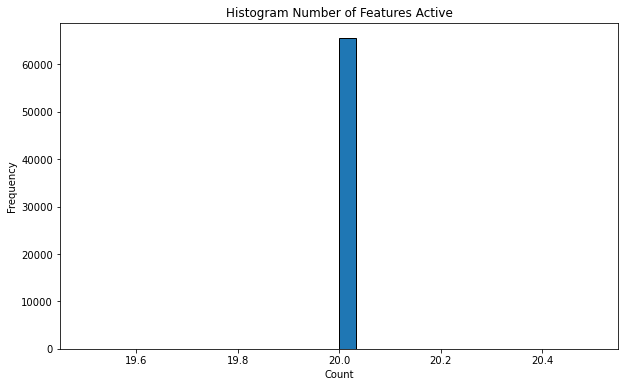

In [92]:
xb, yb = get_batch('train')
tokens = xb
embedding = model.forward(tokens, return_residuals=model_embedding_layer).view(-1, C)
sae_activations = sae(embedding)['feature_activations']

print(sae_activations.shape)

nonzero_counts = (sae_activations != 0)
features_active_per_token = nonzero_counts.sum(dim=-1)


import matplotlib.pyplot as plt

# Plot histogram of random_counts
plt.figure(figsize=(10, 6))
plt.hist(features_active_per_token.cpu().detach().numpy(), bins=30, edgecolor='black')
plt.title('Histogram Number of Features Active')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()


# Sanity Check

One day, a little girl na
torch.Size([16384])
tensor(20, device='cuda:0')


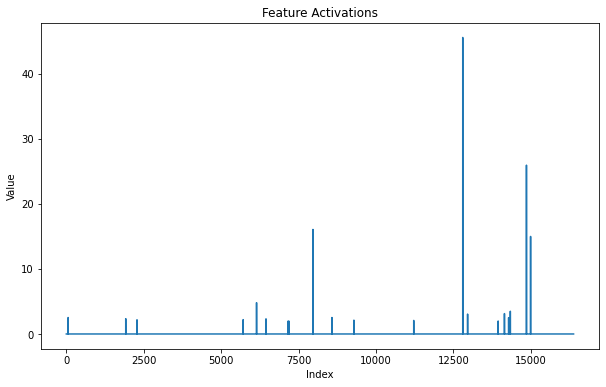

tensor(20, device='cuda:0')


In [93]:
start_idx = 0
characters = 25

text = text[start_idx:start_idx+characters]
print(text)

embedding =  model.get_embedding(text)

sae_output = sae(embedding)

features = sae_output['feature_activations']
print(features.shape)
print(active_features_per_token(features))

import matplotlib.pyplot as plt

# Plot the feature activations
plt.figure(figsize=(10, 6))
plt.plot(features.cpu().detach().numpy().flatten())
plt.title('Feature Activations')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

nonzero_counts = (features != 0.0)
print(nonzero_counts.sum())


# Data Struct